In [1]:
#Deep Q Network for ENO
#Resetting the battery to BOPT on each day during training
#Increase no. of actions to 10
#Decrease hidden layer size from 50 to 10
#Medium Reward

In [2]:
%matplotlib inline

In [3]:
import pulp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import numpy as np
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
np.random.seed(230228)

In [5]:
# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
LAMBDA = 0.8                # parameter decay
TARGET_REPLACE_ITER = 24    # target update frequency (every day)
MEMORY_CAPACITY = 24*7      # store upto one week worth of memory   

N_ACTIONS = 10 #no. of duty cycles (0,1,2,3,4)
N_STATES = 4 #number of state space parameter [batt, enp, henergy, fcast]

In [6]:
class ENO(object):
    def __init__(self, year=2010):
        self.year = year
        self.day = None
        self.hr = None
        
        self.TIME_STEPS = None
        self.NO_OF_DAYS = None
        
        self.BMIN = 0.0
        self.BMAX = 40000.0 #Battery capacity
        self.BOPT = 0.6 * self.BMAX #Assuming 60% of battery is the optimal level
        self.HMAX = 3000
        
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #matrix with forecast values for each day
        
        self.batt = None #battery variable
        self.enp = None #enp at end of hr
        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
    
    #function to map total day energy into day_state
    def get_day_state(self,tot_day_energy):
        if (tot_day_energy < 2500):
            day_state = 0
        elif (2500 <= tot_day_energy < 5000):
            day_state = 1
        elif (5000 <= tot_day_energy < 8000):
            day_state = 2
        elif (8000 <= tot_day_energy < 10000):
            day_state = 3
        elif (10000 <= tot_day_energy < 12000):
            day_state = 4
        else:
            day_state = 5
        return int(day_state)

    #function to get the solar data for the given year and prep it
    def get_data(self):
        filename = str(self.year)+'.csv'
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(filename, skiprows=4, encoding='shift_jisx0213', usecols=[4])
        
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values
        solar_energy = np.array([i *0.0165*1000000*0.15*1000/(60*60) for i in solar_radiation])
        
        #reshape solar_energy into no_of_daysx24 array
        _senergy = solar_energy.reshape(-1,24)
        _senergy[np.isnan(_senergy)] = 0 #convert missing data in CSV files to zero
        self.senergy = _senergy
        
        
        #create a perfect forecaster
        tot_day_energy = np.sum(_senergy, axis=1) #contains total energy harvested on each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_energy)
        
        return 0
    
    def reset(self):
        
        self.get_data() #first get data for the given year
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        print("Environment is RESET")
        
        self.day = 0
        self.hr = 0
        
        self.batt = self.BOPT #battery returns to optimal level
        self.enp = self.BOPT - self.batt #enp is reset to zero
        self.henergy = self.senergy[self.day][self.hr] 
        self.fcast = self.fforecast[self.day]
        
        state = [self.batt/self.BMAX, self.enp/(self.BMAX/2), self.henergy/self.HMAX, self.fcast/5] #normalizing all state values within [0,1] interval
        reward = 0
        done = False
        info = "RESET"
        return [state, reward, done, info]
    
    
    #reward function
    def rewardfn(self):
        mu = 0
        sig = 500
        return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((self.enp - mu)/sig, 2.)/2)) * 1000000)-400

#         if(np.abs(self.enp) <= 2400): #24hr * 100mW/hr
#             return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((self.enp - mu)/sig, 2.)/2)) * 1000000)
#         else:
#             return -100 - 0.05*np.abs(self.enp)
    
    def step(self, action):
        done = False
        info = "OK"
#         print("Next STEP")
        
        reward = 0
        e_consumed = (action+1)*50
        
        self.batt += (self.henergy - e_consumed)
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.enp = self.BOPT - self.batt
        
        if(self.hr < self.TIME_STEPS - 1):
            self.hr += 1
            self.henergy = self.senergy[self.day][self.hr] 
        else:
            if(self.day < self.NO_OF_DAYS -1):
                reward = self.rewardfn() #give reward only at the end of the day
                self.hr = 0
                self.day += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                reward = self.rewardfn()
                done = True
                info = "End of the year"
                
        _state = [self.batt/self.BMAX, self.enp/(self.BMAX/2), self.henergy/self.HMAX, self.fcast/5]
        return [_state, reward, done, info]

In [7]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 10)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(10, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [8]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        print("Neural net")
        print(self.eval_net)

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
dqn = DQN()


eno = ENO(2010)
print('\nCollecting experience...')
s, r, done, info = eno.reset()
record = np.empty(4)

while True:
#     print([eno.day, eno.hr])

    a = dqn.choose_action(s)
    
    #state = [batt, enp, henergy, fcast]
    record = np.vstack((record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
#     print("Action is" , a)
    # take action
    s_, r, done, info = eno.step(a)
#     print([s_,r])
#     print("\n")
    if eno.hr == 0:
        eno.batt = eno.BOPT #resetting the battery to the optimal value for each day
    dqn.store_transition(s, a, r, s_)

    if dqn.memory_counter > MEMORY_CAPACITY:
        dqn.learn()

    if done:
        print("End of Data")
        break
       
    s = s_

Neural net
Net(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=10, bias=True)
)

Environment is RESET
End of Data


In [10]:
record = np.delete(record, 0, 0) #remove the first row which is garbage

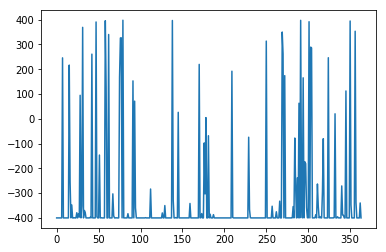

In [11]:
reward_rec = record[:,2]
reward_rec = reward_rec[reward_rec != 0]
plt.plot(reward_rec)

In [12]:
TIME_AXIS = np.arange(0,eno.TIME_STEPS)

In [13]:
# for DAY in range(eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(10,4))
#     st = fig.suptitle("DAY %s" %(DAY))

#     ax1 = fig.add_subplot(141)
#     ax1.plot(record[START:END,0])
#     ax1.set_title("Battery")
#     ax1.set_ylim([0,1])

#     ax2 = fig.add_subplot(142)
#     ax2.plot(record[START:END,1])
#     ax2.set_title("Harvested Energy")
#     ax2.set_ylim([0,1])

#     ax3 = fig.add_subplot(144)
#     ax3.axis('off')
#     if END < (eno.NO_OF_DAYS*eno.TIME_STEPS):
#         plt.text(0.5, 0.5, "REWARD = %.2f\n" %(test_record[END,2]),fontsize=14, ha='center')

#     ax4 = fig.add_subplot(143)
#     ax4.plot(record[START:END,3])
#     ax4.set_title("Action")
#     ax4.set_ylim([0,N_ACTIONS])

#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()


In [18]:
print('\nTesting...')
s, r, done, info = eno.reset()
test_record = np.empty(4)

while True:
#     print([eno.day, eno.hr])

    a = dqn.choose_action(s)
    
    #state = [batt, enp, henergy, fcast]
    test_record = np.vstack((test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
#     print("Action is" , a)
    # take action
    s_, r, done, info = eno.step(a)
#     print([s_,r])
#     print("\n")
    if eno.hr == 0:
        eno.batt = eno.BOPT #resetting the battery to the optimal value for each day
   
    if done:
        print("End of Data")
        break
       
    s = s_


Testing...
Environment is RESET
End of Data


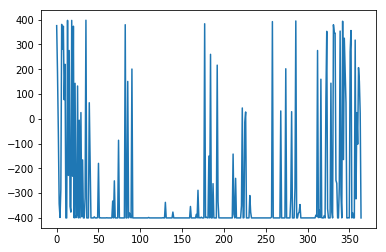

In [23]:
test_reward_rec = test_record[:,2]
test_reward_rec = test_reward_rec[test_reward_rec != 0]
plt.plot(test_reward_rec)

In [20]:
# for DAY in range(eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(10,4))
#     st = fig.suptitle("DAY %s" %(DAY))

#     ax1 = fig.add_subplot(141)
#     ax1.plot(test_record[START:END,0])
#     ax1.set_title("Battery")
#     ax1.set_ylim([0,1])

#     ax2 = fig.add_subplot(142)
#     ax2.plot(test_record[START:END,1])
#     ax2.set_title("Harvested Energy")
#     ax2.set_ylim([0,1])

#     ax3 = fig.add_subplot(144)
#     ax3.axis('off')
#     if END < (eno.NO_OF_DAYS*eno.TIME_STEPS):
#         plt.text(0.5, 0.5, "REWARD = %.2f\n" %(test_record[END,2]),fontsize=14, ha='center')

#     ax4 = fig.add_subplot(143)
#     ax4.plot(test_record[START:END,3])
#     ax4.set_title("Action")
#     ax4.set_ylim([0,N_ACTIONS])

#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()

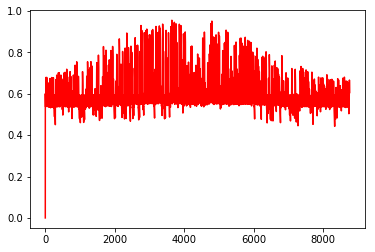

In [22]:
plt.plot(test_record[:,0],'r')

In [25]:
#Average Battery Percentage
np.mean(test_record[:,0])

0.6256983185424039